In [126]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [127]:
def estimate(Mk,xbar,z):
    
    Kk = Mk @ Hk.T @ np.linalg.inv(Hk @ Mk @ Hk.T + V)

    Pk = (I - Kk @ Hk) @ Mk
    
    xhat = xbar.reshape(6,1) + Kk @ (z - Hk @ xbar.reshape(6,1))
    
    xhat = xhat.reshape(6,1)
    
    return Pk, xhat 

def predict(Pk, xhat):
    
    Mk = np.dot(Ak,(Pk @ Ak.T)) + np.dot(Gk,(W @ Gk.T))

    xbar = Ak @ xhat 

    xbar = xbar.reshape(6,1)
    
    return Mk, xbar

In [138]:
df = pd.read_csv('/home/parth/Desktop/uni_stuff/sensor_fusion/project/final_csv_files/cam_lidar_xyz_20Hz.csv')
df.columns = ['time','camera_x','camera_y','camera_z','lidar_x','lidar_y','lidar_z']
gt_hero = pd.read_csv('/home/parth/Desktop/uni_stuff/sensor_fusion/project/final_csv_files/hero_xyz_20Hz.csv')
gt_hero.columns = ['time','x','y','z']

Ak = np.array([[1,0.05,0,0,0,0], [0,1,0,0,0,0], [0,0,1,0.05,0,0], [0,0,0,1,0,0], [0,0,0,0,1,0.05], [0,0,0,0,0,1]]).reshape(6,6)
Hk = np.array([[1,0,0,0,0,0], [0,0,1,0,0,0], [0,0,0,0,1,0], [1,0,0,0,0,0], [0,0,1,0,0,0], [0,0,0,0,1,0] ]).reshape(6,6)

Gk = np.array([[0.5 * (0.05)**2, 0, 0],
               [(0.05), 0, 0],
               [0, 0.5 * (0.05)**2, 0],
               [0, (0.05), 0],
               [0, 0 , 0.5 * (0.05) **2],
               [0, 0 ,(0.05)]]).reshape(6,3)
# Gk = np.array([[0.5*(0.05)**2],[0.05], [0.5*(0.05)**2], [0.05], [0.5*(0.05)**2], [0.05]]).reshape(6,1)

I = np.eye(6)

Mk = np.eye(6)

# Mk[1,1] = 100
# Mk[3,3] = 100
# Mk[5,5] = 100

Pk = np.eye(6)

# Pk[1,1] = 100
# Pk[3,3] = 100
# Pk[5,5] = 100

x_bar = np.zeros((6, len(df)+1)).reshape(6,len(df)+1)
x_hat = np.zeros((6, len(df)+1)).reshape(6,len(df)+1)
x = np.zeros((6,len(df)+1)).reshape(6,(len(df)+1))
z = np.zeros((12,len(df)+1)).reshape(12,(len(df)+1))

x0 = np.array([[0], [0], [0], [0], [0], [0]]).reshape(6,1)

x_bar[:,0] = x0[:,0]
x[:,0] = x0[:, 0]
x_hat[:,0] = x0[:,0]

vk = np.random.normal(0,0.001)
wk = np.random.normal(0,0.01)

# V = np.array([[vk**2,0,0,0],[0,vk**2,0,0], [0,0,vk**2,0], [0,0,0,vk**2]])
# V = block_diag(V,V,V)

# V = np.diag([ 0.001, 0.001, 0.001, 5, 5, 5])
V = np.diag([ 0.01, 0.01, 0.01, 0.08, 0.08, 0.08])


W = np.diag([wk**2,wk**2,wk**2 ])

In [139]:
for i in range(0 ,len(df)):

    if i < 1: # startup
        pass 

    else:  # not startup
        
        Mk, xbar = predict(Pk, x_hat[:,i])

        x_bar[:,i] = xbar.flatten()

    z_m1 = np.array([ (df['camera_x'][i]), (df['camera_y'][i]), (df['camera_z'][i]) ]).reshape(3,1)
    z_m2 = np.array([ (df['lidar_x'][i]), (df['lidar_y'][i]), (df['lidar_z'][i]) ]).reshape(3,1)
    
    z_m = np.vstack([z_m1, z_m2])
    
    pk, xhat = estimate(Mk,x_bar[:,i],z_m)

    Pk = pk
    
    x_hat[:,i+1] = xhat.flatten()


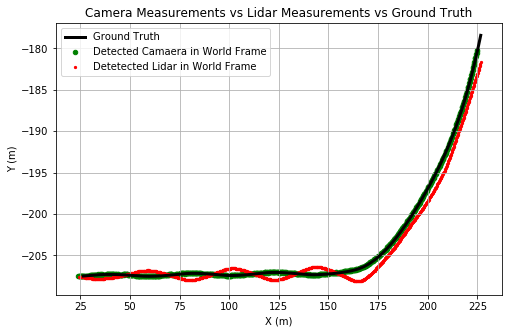

In [140]:
plt.figure(figsize=(8,5))
# rn = np.arange(0,len(df+1))
plt.plot(gt_hero['x'],gt_hero['y'], linewidth = 3, c ='black', label = 'Ground Truth')
plt.scatter(df['camera_x'],df['camera_y'],s=20, c='g', label = 'Detected Camaera in World Frame')
plt.scatter(df['lidar_x'],df['lidar_y'],s=5, c ='r', label = 'Detetected Lidar in World Frame')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Camera Measurements vs Lidar Measurements vs Ground Truth')
plt.legend()
plt.grid()

In [151]:
print(np.sqrt(mean_squared_error(gt_hero['x'],df['camera_x'],squared=False)))
print(np.sqrt(mean_squared_error(gt_hero['y'],df['camera_y'],squared=False)))

1.53-0.75

1.5363254657463956
0.760694480337307


0.78

In [150]:
print(np.sqrt(mean_squared_error(gt_hero['x'],df['lidar_x'],squared=False)))
print(np.sqrt(mean_squared_error(gt_hero['y'],df['lidar_y'],squared=False)))

1.3482624917386856
1.1261527173905694


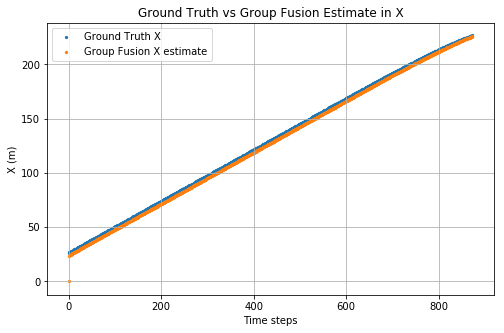

In [143]:
plt.figure(figsize=(8,5))
rn = np.arange(0,len(df+1))
plt.scatter(rn,gt_hero['x'],s=5, label = 'Ground Truth X')
plt.scatter(rn,x_hat[0,:874],s=5, label = 'Group Fusion X estimate')
# plt.scatter(x_hat[0,:874], x_hat[2,:874],s=5)
plt.ylabel('X (m)')
plt.xlabel('Time steps')
plt.title('Ground Truth vs Group Fusion Estimate in X')
plt.legend()
plt.grid()

In [152]:
print(np.sqrt(mean_squared_error(gt_hero['x'],x_hat[0,:874],squared=False)))
print(np.sqrt(mean_squared_error(gt_hero['y'],x_hat[2,:874],squared=False)))



print((0.87 + 2.66)/2)

1.6202378099992811
2.666974480849537
1.7650000000000001


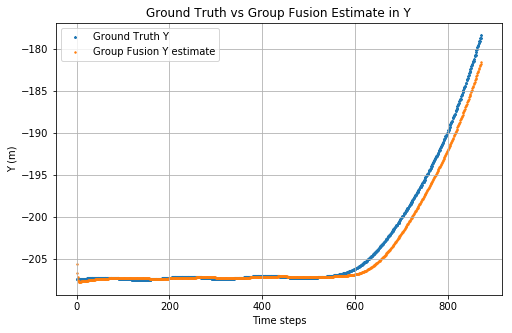

In [145]:
plt.figure(figsize=(8,5))
rn = np.arange(0,len(df+1))
plt.scatter(rn[:873],gt_hero['y'][1:874],s=5, label = 'Ground Truth Y', marker='*')
plt.scatter(rn[:873],x_hat[2,1:874],s=2, label = 'Group Fusion Y estimate')
plt.ylabel('Y (m)')
plt.xlabel('Time steps')
plt.title('Ground Truth vs Group Fusion Estimate in Y')
plt.legend()
plt.grid()

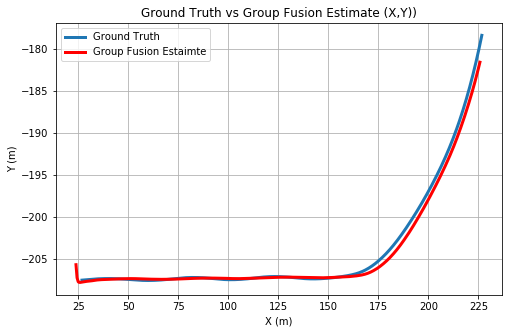

In [146]:
plt.figure(figsize=(8,5))
plt.plot(gt_hero['x'][1:874],gt_hero['y'][1:874], linewidth = 3,label = 'Ground Truth')
plt.plot(x_hat[0,1:874],x_hat[2,1:874],label = 'Group Fusion Estaimte', linewidth=3, c='red')
plt.ylabel('Y (m)')
plt.xlabel('X (m)')
plt.title('Ground Truth vs Group Fusion Estimate (X,Y))')
plt.legend()
plt.grid()

In [10]:
# df = pd.read_csv('/home/parth/Desktop/uni_stuff/sensor_fusion/project/final_csv_files/cam_lidar_xyz_20Hz.csv')
# df.columns = ['time','camera_x','camera_y','camera_z','lidar_x','lidar_y','lidar_z']

# Ak = np.array([[1,0.05,0,0,0,0], [0,1,0,0,0,0], [0,0,1,0.05,0,0], [0,0,0,1,0,0], [0,0,0,0,1,0.05], [0,0,0,0,0,1]]).reshape(6,6)
# Hk1 = np.array([[1,0,0,0,0,0], [0,0,0,0,0,0], [0,0,1,0,0,0], [0,0,0,0,0,0], [0,0,0,0,1,0], [0,0,0,0,0,0]]).reshape(6,6)
# Hk2 = np.array([[1,0,0,0,0,0], [0,0,0,0,0,0], [0,0,1,0,0,0], [0,0,0,0,0,0], [0,0,0,0,1,0], [0,0,0,0,0,0]]).reshape(6,6)

# Hk = np.hstack((Hk1.T,Hk2.T)).T

# # Gk = np.array([[0],[0.5*(0.05)**2], [0], [(0.5*0.05)**2], [0], [0.5*(0.05)**2]]).reshape(6,1)
# Gk = np.array([[0.5*(0.05)**2],[0.05], [0.5*(0.05)**2], [0.05], [0.5*(0.05)**2], [0.05]]).reshape(6,1)

# I = np.eye(6)

# Mk = np.eye(6)

# Mk[1,1] = 1000
# Mk[3,3] = 1000
# Mk[5,5] = 1000

# Pk = np.eye(6)

# # Pk[1,1] = 1000
# # Pk[3,3] = 1000
# # Pk[5,5] = 1000

# x_bar = np.zeros((6, len(df)+1)).reshape(6,len(df)+1)
# x_hat = np.zeros((6, len(df)+1)).reshape(6,len(df)+1)
# x = np.zeros((6,len(df)+1)).reshape(6,(len(df)+1))
# z = np.zeros((12,len(df)+1)).reshape(12,(len(df)+1))

# x0 = np.array([[0], [0], [0], [0], [0], [0]]).reshape(6,1)

# x_bar[:,0] = x0[:,0]
# x[:,0] = x0[:, 0]
# x_hat[:,0] = x0[:,0]

# vk = np.random.normal(0,0.0001)
# wk = np.random.normal(0,0.0001)

# V = np.array([[vk**2,0,0,0],[0,vk**2,0,0], [0,0,vk**2,0], [0,0,0,vk**2]])
# V = block_diag(V,V,V)
# W = np.array([[wk**2]])

In [11]:
# for i in range(0 ,len(df)):
    
# #     z[:,i] = calcmeas_model(x[:,i],vk).flatten()

#     if i < 1: # startup
#         pass 

#     else:  # not startup
        
#         Mk, xbar = predict(pk, x_hat[:,i-i])

#         x_bar[:,i] = xbar.flatten()

# #         xsim = calcprocess_model(x[:,i-1])

# #         x[:,i] = xsim.flatten()

#     z_m1 = np.array([[(df['camera_x'][i])], [0], [(df['camera_y'][i])], [0], [(df['camera_z'][i])], [0]]).reshape(6,1)
#     z_m2 = np.array([[(df['lidar_x'][i])], [0], [(df['lidar_y'][i])], [0], [(df['lidar_z'][i])], [0]]).reshape(6,1)
    
#     z_m = np.hstack((z_m1.T, z_m2.T)).T
    
#     pk, xhat = estimate(Mk,x_bar[:,i],z_m)
    
#     x_hat[:,i] = xhat.flatten()
